In [5]:
!pip install perlin_noise

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.signal import argrelextrema
import pickle
from perlin_noise import PerlinNoise
from scipy.integrate import simps
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

# Eye Data Collection


In [21]:
def detect_eye_blink_peaks(df, column_name, threshold=0.7):
    """
    Detects the peak of eye blinks.

    :param df: DataFrame containing all blendshape data.
    :param column_name: The name of the column to analyze for eye blinks.
    :param threshold: The threshold value above which an eye blink is considered to have started.
    :return: A list of frame numbers where the peak of eye blinks were detected.
    """
    blink_peaks = []
    in_blink = False
    peak_value = 0
    peak_frame = None

    for index, row in df.iterrows():
        current_value = row[column_name]
        if current_value > threshold and not in_blink:
            # Start of a new blink
            in_blink = True
            peak_value = current_value
            peak_frame = index
        elif in_blink:
            if current_value > peak_value:
                # Update peak value and frame
                peak_value = current_value
                peak_frame = index
            elif current_value <= threshold:
                # End of a blink
                blink_peaks.append(peak_frame)
                in_blink = False

    return blink_peaks

def find_half_max_jaw_open_frames(df, column_name):
    """
    Finds the frames where the 'Jaw Open' value is half of its maximum in the dataset.

    :param df: DataFrame containing all blendshape data.
    :param column_name: The name of the column to analyze for jaw open.
    :return: Two list of frame numbers where the jaw open value is half of its maximum, first one is unormalized, second one is normalized.
    """
    max_value = df[column_name].max()
    half_max_value = max_value / 2

    # Identify frames where the value crosses half of the maximum
    frames = []
    for index, row in df.iterrows():
        if abs(row[column_name] - half_max_value) < 0.05:  # Allowing a small tolerance
            frames.append(index)

    return [frames[0], frames[-1]], [frames[0]/len(df[column_name]), frames[-1]/len(df[column_name])]

def find_blink_duration(df, column_name, blink_peak_frames):
    """
    Finds the duration of each blink.

    :param df: DataFrame containing all blendshape data.
    :param column_name: The name of the column to analyze for eye blinks.
    :return: A list of blink duration.
    """
    blink_durations = []

    for peak_frame in blink_peak_frames:
        # Initialize start and end frame to the peak frame
        start_frame, end_frame = peak_frame, peak_frame

        sharp_decrease = False
        # Find start of blink: move left until the condition is met
        while start_frame > 0:
            diff = df[column_name].iloc[start_frame] - df[column_name].iloc[start_frame - 1]
            if (sharp_decrease and diff <= 0.01) or (not sharp_decrease and diff <= 0):
                break
            if diff > 0.3:
                sharp_decrease = True
            start_frame -= 1

        sharp_decrease = False
        # Find end of blink: move right until the condition is met
        while end_frame < len(df) - 1:
            diff = df[column_name].iloc[end_frame] - df[column_name].iloc[end_frame + 1]
            if (sharp_decrease and diff <= 0.01) or (not sharp_decrease and diff <= 0):
                break
            if diff > 0.3:
                sharp_decrease = True
            end_frame += 1

        # Calculate duration
        duration = end_frame - start_frame + 1
        blink_durations.append(duration)

    return blink_durations

In [ ]:
# Initialize dictionaries and lists
normalized_blink_frames = {}
normalized_half_open_frames = {}
unnormalized_half_open = []
total_time = []
num_blink = []
durations = []
blink_data = {}

# Read and process each CSV file
csv_files = glob.glob('*.csv')
for file_path in csv_files:
    data = pd.read_csv(file_path)
    total_frames = len(data)

    blink_peak_frames = detect_eye_blink_peaks(data, 'EyeBlinkLeft')
    blink_durations = find_blink_duration(data, 'EyeBlinkLeft', blink_peak_frames)
    unnorm_jaw, jaw_open_half_max_frames = find_half_max_jaw_open_frames(data, 'JawOpen')

    normalized_blink_peak_frames = [frame / total_frames for frame in blink_peak_frames]
    jaw_open_start, jaw_open_end = jaw_open_half_max_frames[0], jaw_open_half_max_frames[1]
    temp = [[], [], []]

    # Categorize normalized blink frames
    for f in normalized_blink_peak_frames:
        if f < jaw_open_start:
            temp[0].append(f)
        elif f > jaw_open_end:
            temp[2].append(f)
        else:
            temp[1].append(f)

    normalized_blink_frames[file_path] = temp
    normalized_half_open_frames[file_path] = jaw_open_half_max_frames
    unnormalized_half_open.append(unnorm_jaw)
    total_time.append(total_frames)
    num_blink.append([len(x) for x in temp])
    durations += blink_durations

    # Print file details
    print(file_path)
    print("jaw open frames", unnorm_jaw)
    print("peak", blink_peak_frames)
    print("number", [len(x) for x in temp])
    print("duration", blink_durations, '\n')


avg_over_all_times = []
avg_over_mouth_open_times = []
for i in range(len(total_time)):
    if sum(num_blink[i]):
        avg_over_all_times.append(total_time[i]/sum(num_blink[i]))
    if num_blink[i][1]:
        avg_over_mouth_open_times.append((unnormalized_half_open[i][1] - unnormalized_half_open[i][0])/num_blink[i][1])

a = np.array(avg_over_all_times)
print("Average over all time ", np.mean(np.array(a)))
a = np.delete(a, a.argmin())
a = np.delete(a, a.argmax())
print("Average over all time(min and max removed) ",np.mean(np.array(a)))


amot = np.array(avg_over_mouth_open_times)
avg_time = np.mean(np.array(amot))
print("Average over mouth open time ",avg_time)
amot = np.delete(amot, amot.argmin())
amot = np.delete(amot, amot.argmax())
print("Average over mouth open time(min and max removed) ", np.mean(np.array(amot)))

blink_data['avg_over_all_times'] = avg_over_all_times
blink_data['avg_over_mouth_open_times'] = avg_over_mouth_open_times
blink_data['avg_time'] = avg_time

xs = []

for i, f in enumerate(normalized_blink_frames):
    if len(normalized_blink_frames[f][0]) != 0:
        length = normalized_half_open_frames[f][0]
        for b in normalized_blink_frames[f][0]:
            x = b / length
            xs.append(x/4)

    if len(normalized_blink_frames[f][1]) != 0:
        length = normalized_half_open_frames[f][1] - normalized_half_open_frames[f][0]
        for b in normalized_blink_frames[f][1]:
            x = (b - normalized_half_open_frames[f][0]) / length
            xs.append(x/2 + 0.25)

    if len(normalized_blink_frames[f][2]) != 0:
        length = 1 - normalized_half_open_frames[f][1]
        for b in normalized_blink_frames[f][2]:
            x = (b - normalized_half_open_frames[f][1]) / length
            xs.append(x/4 + 0.75)

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

# Blink Peak
x = np.array(xs)

# Creating a histogram with bins=8
hist, bin_edges = np.histogram(x, bins=8, density=True)

# Midpoints of bins
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generating a smooth curve
x_smooth = np.linspace(bin_midpoints.min(), bin_midpoints.max(), 300)
y_smooth = make_interp_spline(bin_midpoints, hist)(x_smooth)

# Calculate the area under the y_smooth curve
area_under_curve = simps(y_smooth, x_smooth)

# Normalize y_smooth to make it a PDF
y_smooth_pdf = y_smooth / area_under_curve


blink_data['peak'] = {'x_smooth': x_smooth, 'y_smooth_pdf': y_smooth_pdf}

In [ ]:
# Duration
data = [x for x in durations if x <= 100]

# Creating a histogram with bins=8
hist, bin_edges = np.histogram(data, bins=4, density=True)

# Midpoints of bins
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# Generating a smooth curve
x_smooth = np.linspace(bin_midpoints.min(), bin_midpoints.max(), 30000)
y_smooth = make_interp_spline(bin_midpoints, hist)(x_smooth)

# Calculate the area under the y_smooth curve
area_under_curve = simps(y_smooth, x_smooth)

# Normalize y_smooth to make it a PDF
y_smooth_pdf = y_smooth / area_under_curve


blink_data['duration'] = {'x_smooth': x_smooth, 'y_smooth_pdf': y_smooth_pdf}

In [ ]:
# Store blink data pdfs to json file
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

with open("eye_data.json", "w") as outfile:
    json.dump(blink_data, outfile, cls=NumpyEncoder)

# Synthesize eye related blendshape values

In [17]:
######################## Skewed Generalized Normal Distribution ########################
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import gamma
from scipy.optimize import minimize_scalar

# Define the PDF of the Generalized Normal Distribution
def gennorm_pdf(x, beta, mean, sigma):
    return np.exp(-np.abs((x - mean) / sigma)**beta) / (2 * sigma * gamma(1/beta) * (1/beta)**(1/beta))

# Define a skewing function using the CDF of the normal distribution
def skewing_function(x, alpha):
    return 2 * norm.cdf(alpha * x)

# Internal function to calculate the amplitude A
def _calculate_amplitude(beta, max_value, sigma, y_min, mean, alpha):
    def objective_function(A):
        y_values = A * gennorm_pdf(x_values, beta, mean, sigma) * skewing_function(x_values, alpha) + y_min
        return np.abs(max(y_values) - max_value)

    x_values = np.linspace(mean - 5*sigma, mean + 5*sigma, 1000)
    result = minimize_scalar(objective_function)
    return result.x

# Modified function to calculate the skewed GND PDF
def skewed_gennorm_pdf(x, beta, max_value, sigma, y_min, mean, alpha=5):
    A = _calculate_amplitude(beta, max_value, sigma, y_min, mean, alpha)
    return A * gennorm_pdf(x, beta, mean, sigma) * skewing_function(x, alpha) + y_min
###########################################################################################

In [18]:
######################## Helper Functions to Generate Random Blink ########################
def is_too_close(new_x, selected_x, min_distance):
    for point in selected_x:
        if abs(new_x - point) < min_distance:
            return True
    return False

def segment_and_normalize_pdf(x, y_pdf, x_range):
    indices = (x >= x_range[0]) & (x <= x_range[1])
    x_segment = x[indices]
    y_pdf_segment = y_pdf[indices]
    area = simps(y_pdf_segment, x_segment)
    y_pdf_segment_normalized = y_pdf_segment / area
    return x_segment, y_pdf_segment_normalized

def random_points(x, y, n=1):
    cdf = cumtrapz(y, x, initial=0)
    cdf /= cdf[-1]  # Normalize
    inverse_cdf = interp1d(cdf, x)
    random_samples = np.random.rand(n)
    return inverse_cdf(random_samples)

def random_peaks(x_smooth, y_smooth_pdf, num_points):
    length = 1 / num_points
    min_distance = length / 2
    ranges = [(i * length, (i + 1) * length) for i in range(num_points)]

    selected_x = []

    for x_range in ranges:
        x_segment, y_pdf_segment = segment_and_normalize_pdf(x_smooth, y_smooth_pdf, x_range)

        attempts = 0
        while attempts < 10:
            random_x = random_points(x_segment, y_pdf_segment)[0]
            if not is_too_close(random_x, selected_x, min_distance):
                selected_x.append(random_x)
                break
            attempts += 1
    return selected_x
#################################### End of Helper Functions ####################################


####################### Helper Functions to Generate Eye Blendshape Curves ######################
def find_second_peak_index(curve, mean):
    argmax = np.argmax(curve[mean:])
    return mean + argmax

# Find the first intersection point between two curves after xt. Returns the x-value of the first intersection point.
def find_first_intersection(x, curve1, curve2, xt):
    for i in range(xt, len(x) - 1):
        if (curve1[i] - curve2[i]) * (curve1[i+1] - curve2[i+1]) <= 0:
            return x[i]
    return None
#################################### End of Helper Functions ####################################


############################### Helper Functions for Perlin noise ###############################
# Generate perlin noise
def generate_perlin_noise(x, y):
    dy = np.gradient(y, x)
    threshold = 0.1
    smooth_regions = np.abs(dy) < threshold
    noise = PerlinNoise(octaves=0.3)
    scale = 0.1
    y_noise = np.array([noise([xi * scale]) if smooth else 0 for xi, smooth in zip(x, smooth_regions)])

    return y_noise
#################################### End of Helper Functions ####################################

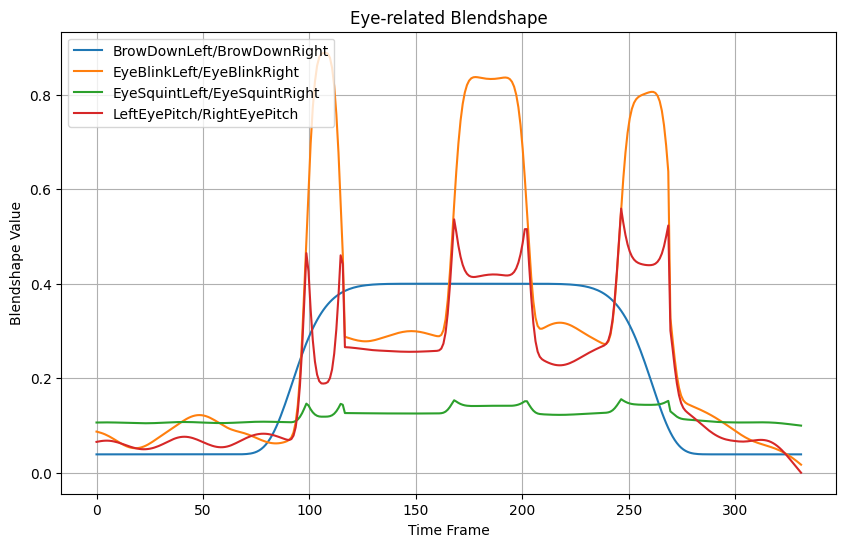

In [25]:
import json
with open('eye_data.json', 'r') as file:
    blink_data = json.load(file)

with open('models.pickle', 'rb') as handle:
      models = pickle.load(handle)

# second number if the user specified duration in unit seconds, 60 fps
duration = int(60 * 5.5)
# user can specify if they w
eyes_open = True
# use can specify openness from 0 to 1
openness = 0.8

jaw_open_max_value = openness
jaw_open_beta = models["JawOpen_beta"].predict([1, jaw_open_max_value])[0]
jaw_open_mean = models["JawOpen_mean"].predict([1, duration])[0]
jaw_open_sigma = models["JawOpen_sigma"].predict([1, duration])[0]
jaw_open_y_min = models["JawOpen_y_min"].predict([1, duration, jaw_open_max_value])[0]

x = np.linspace(0, duration+1, duration)
if eyes_open:
    num_points = round(duration/blink_data['avg_time'])

    # Randomly generating blink peaks and duration
    selected_peak = random_peaks(np.asarray(blink_data['peak']['x_smooth']), np.asarray(blink_data['peak']['y_smooth_pdf']), num_points)
    selected_peak = np.sort((np.array(selected_peak) * duration).astype(int))

    selected_duration = (random_points(np.asarray(blink_data['duration']['x_smooth']), np.asarray(blink_data['duration']['y_smooth_pdf']), num_points)).astype(int)
    if min(selected_duration) >= 20:
        idx = np.argmax(selected_duration)
        selected_duration[idx] = random.randint(8, 19)

    eye_blink = np.zeros(x.shape)
    eye_lookdown = np.zeros(x.shape)
    alpha = 20
    prev_mean = 0
    inter_x = 0
    inter_x_look = 0
    for i in range(num_points):
        if i == 0:
            y_min = random.uniform(0.05, 0.15)
        elif i != (num_points - 1):
            y_min = random.uniform(0.2, 0.3)
        mean = selected_peak[i]
        max_value = random.uniform(0.8, 1)
        sigma = selected_duration[i]/2
        beta = selected_duration[i]/5.65
        cur_blink = skewed_gennorm_pdf(x, beta, max_value, sigma, y_min, mean, alpha)
        tmp = skewed_gennorm_pdf(x, beta, max_value - y_min, sigma, y_min, mean, alpha)
        cur_lookdown = np.minimum(cur_blink, 1 - tmp)

        if eye_blink.all() == 0:
            eye_blink = cur_blink
            eye_lookdown = cur_lookdown
        else:
            inter_x = find_first_intersection(x, eye_blink, cur_blink, prev_mean)
            inter_x_look = find_first_intersection(x, eye_lookdown, cur_lookdown, second_peak_idx)
            if inter_x is not None:
                idx = np.where(x >= inter_x)[0][0]
                eye_blink[idx:] = cur_blink[idx:]
            if inter_x_look is not None:
                idx_look = np.where(x >= inter_x_look)[0][0]
                eye_lookdown[idx_look:] = cur_lookdown[idx_look:]
        prev_mean = mean
        second_peak_idx = find_second_peak_index(cur_lookdown, mean)

    # Smoothly decrease the last part of the curve
    b = duration
    a = second_peak_idx
    decrease_factors = np.linspace(eye_blink[a], 0.05, b - a)
    eye_blink[a:b] = eye_blink[a:b] * decrease_factors
    eye_lookdown[a:b] = eye_lookdown[a:b] * decrease_factors

    # Add noise to make eye blinks more natural
    noise1 = generate_perlin_noise(x, eye_blink)
    noise2 = generate_perlin_noise(x, eye_lookdown)
    eye_blink_noisy = eye_blink + 0.1 * noise1
    eye_lookdown_noisy = eye_lookdown * 0.98 + 0.1 * noise2 - 0.02
    squint = 0.1 + 0.1 * eye_lookdown_noisy
    half = (min(eye_lookdown) - min(squint))/2
    pitch = (eye_lookdown_noisy - min(eye_lookdown))/2 + min(eye_lookdown) - half
    brow = skewed_gennorm_pdf(x, jaw_open_beta, jaw_open_max_value/2, jaw_open_sigma - 10, jaw_open_y_min, jaw_open_mean+10)

if not eyes_open:
    beta = 50
    max_value = random.uniform(0.95, 1)
    sigma = jaw_open_sigma + 10
    y_min = random.uniform(0.05, 0.1)
    mean = jaw_open_mean
    alpha = 20

    eye_blink = skewed_gennorm_pdf(x, beta, max_value, sigma, y_min, mean, alpha)
    tmp = skewed_gennorm_pdf(x, beta, max_value - y_min, sigma, y_min, mean, alpha)
    eye_lookdown = np.minimum(eye_blink, 1 - tmp)
    frames = jaw_open_mean - jaw_open_sigma

    # Randomly add one blink before or after the eye-closing process
    if frames > 20:
        combined_range = list(range(5, int(frames))) + list(range(int(jaw_open_mean + jaw_open_sigma), duration - 5))
        selected_peak = random.choice(combined_range)
        selected_duration = random.randint(8, 11)

        mean = selected_peak
        max_value = random.uniform(0.8, 1)
        sigma = selected_duration/2
        beta = selected_duration/5.65

        eye_blink_rand = skewed_gennorm_pdf(x, beta, max_value, sigma, y_min, mean, alpha)
        eye_blink = np.maximum(eye_blink, eye_blink_rand)
        tmp = skewed_gennorm_pdf(x, beta, max_value, sigma, y_min, mean, alpha)
        eye_lookdown_rand = np.minimum(eye_blink_rand, 1 - tmp)
        eye_lookdown = np.maximum(eye_lookdown, eye_lookdown_rand)

    noise1 = generate_perlin_noise(x, eye_blink)
    noise2 = generate_perlin_noise(x, eye_lookdown)
    eye_blink_noisy = eye_blink + 0.1 * noise1
    eye_lookdown_noisy = eye_lookdown * 0.98 + 0.1 * noise2 - 0.02
    squint = 0.1 + 0.1 * eye_lookdown_noisy
    half = (min(eye_lookdown) - min(squint))/2
    pitch = (eye_lookdown_noisy - min(eye_lookdown))/2 + min(eye_lookdown) - half
    brow = skewed_gennorm_pdf(x, jaw_open_beta, jaw_open_max_value/4*3, jaw_open_sigma - 10, jaw_open_y_min, jaw_open_mean+10)

plt.figure(figsize=(10, 6))
plt.plot(x, brow , label='BrowDownLeft/BrowDownRight')
plt.plot(x, eye_blink_noisy , label='EyeBlinkLeft/EyeBlinkRight')
plt.plot(x, squint , label='EyeSquintLeft/EyeSquintRight')
plt.plot(x, eye_lookdown_noisy , label='LeftEyePitch/RightEyePitch')
plt.xlabel('Time Frame')
plt.ylabel('Blendshape Value')
plt.title('Eye-related Blendshape')
plt.legend()
plt.grid(True)
plt.show()
